# Health Models

In [17]:
## Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# sklearn
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# scipy
from scipy.stats import shapiro

# statsmodels
import statsmodels.api as sm

## Optional Variable Selection
Data: quantile transformed and dummy vars

Response variable: health PC1 detrended by all income vars PC1

In [18]:
## Read data
df = pd.read_csv('./data/data_detrend.csv', index_col='CountySt')

## Response variable selection
select_var = 'PCA_dt_allinc_popstr'
resp_vars = ['PCT_DIABETES_ADULTS13', 'HDM', 'PCA', 'PCA_dt_medinc', 'PCA_dt_allinc', 'PCA_dt_allinc_popstr']
df.drop([v for v in resp_vars if v != select_var], axis=1, inplace=True)

## Remove income vars?
rem_income_vars = True
income_vars = ['MEDHHINC15', 'PCT_LACCESS_HHNV15', 'POVRATE15', 'SNAPSPTH12']
if rem_income_vars:
    df.drop(income_vars, axis=1, inplace=True)
    
## Remove population structure vars?
rem_popstr_vars = True
popstr_vars = ['PCT_18YOUNGER10', 'PCT_65OLDER10']
if rem_popstr_vars:
    df.drop(popstr_vars, axis=1, inplace=True)

## Collinearity Double Check
has_chip_tax and has_food_tax are identical, remove has_chip_tax

In [19]:
# check for collinearity
corr = df.corr().abs().unstack()
corr = corr.sort_values(ascending=False)
print('__________\nCollinear features\n__________')
print('\n'.join([f'{c1}, {c2}: {corr[c1,c2]:.4f}' for c1, c2 in corr.index if c1 != c2 and corr[c1,c2] > 0.7]))

# remove has_chip_tax
df.drop(['has_chip_tax'], axis=1, inplace=True)

__________
Collinear features
__________
has_food_tax, has_chip_tax: 1.0000
has_chip_tax, has_food_tax: 1.0000
DIRSALES_FARMS12, sum_farms: 0.7621
sum_farms, DIRSALES_FARMS12: 0.7621
PCT_LACCESS_SNAP15, PCT_LACCESS_POP15: 0.7544
PCT_LACCESS_POP15, PCT_LACCESS_SNAP15: 0.7544
PCT_NHWHITE10, PCT_HISP10: 0.7062
PCT_HISP10, PCT_NHWHITE10: 0.7062


## Data Partitioning

In [20]:
## standardize
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

## X, y
y = df[select_var]
x_cols = [c for c in df.columns if c != select_var]
X = df[x_cols]

## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## Modeling

### LassoCV
Coordinate descent figure code from: <br> https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py

In [21]:
## Fit LassoCV
lassocv = LassoCV(random_state=10, cv=10).fit(X_train, y_train)

#### Alpha selection

Alpha that minimizes MSE = 2.535e-04


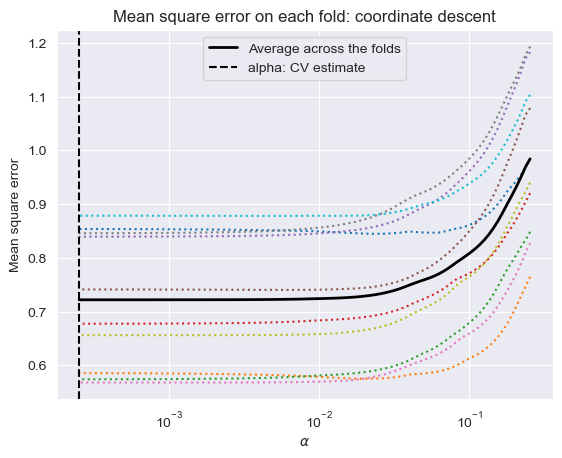

In [22]:
print(f'Alpha that minimizes MSE = {lassocv.alpha_:.3e}')

# plot CV results
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(lassocv.alphas_, lassocv.mse_path_.mean(axis=-1), color="black", label="Average across the folds", linewidth=2)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: coordinate descent")
plt.savefig('data/figures/lassocv coordinate descent.png')
plt.show()

#### Check normality in residuals

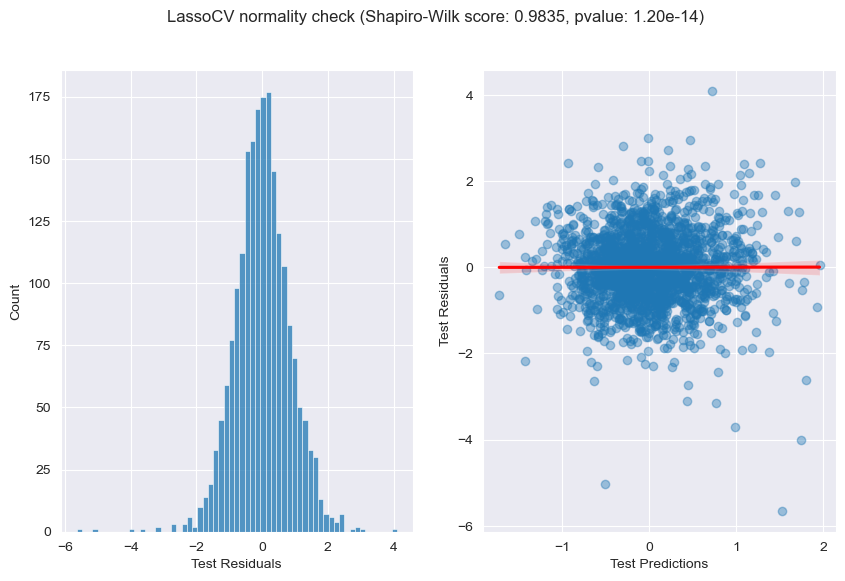

In [23]:
# plot residuals
def check_residuals(X, y, model, save=None):
    pred = model.predict(X)
    res = y - pred
    norm = shapiro(res)
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    sns.histplot(res, ax=axs[0])
    sns.regplot(x=pred, y=res, ax=axs[1], scatter_kws={'alpha':0.4}, line_kws=dict(color="r"))
    axs[0].set_xlabel('Test Residuals')
    axs[1].set_xlabel('Test Predictions')
    axs[1].set_ylabel('Test Residuals')
    fig.suptitle(f'{save} (Shapiro-Wilk score: {norm[0]:.4f}, pvalue: {norm[1]:.2e})')
    if save is not None:
        plt.savefig(f'data/figures/{save}.png')
    plt.show()

check_residuals(X_train, y_train, lassocv, save='LassoCV normality check')

#### Variable selection
No features were removed by LASSO

In [24]:
# print training results
def sklearn_training_results(model, X_train, y_train, has_alpha=False):
    print(f'________ \n{model} \n________')
    if has_alpha:
        alpha = model.alpha_
        print(f'Best alpha: {alpha:.4e}')
    coefs = pd.DataFrame({'feature': X_train.columns, 'coefficients': model.coef_})
    print(f'Top positive coefficients: \n{coefs.sort_values(ascending=False, by='coefficients').head()}')
    print(f'Top negative coefficients: \n{coefs.sort_values(ascending=True, by='coefficients').head()}')
    print(f'# zero coefs = {coefs[coefs['coefficients']==0].shape[0]}, # nonzero coefs = {coefs[coefs['coefficients']!=0].shape[0]} \n{coefs.loc[coefs['coefficients'] == 0, 'feature']}')
    print(f'Training R2: {model.score(X_train, y_train):.4f}')
    
sklearn_training_results(lassocv, X_train, y_train, has_alpha=True)

________ 
LassoCV(cv=10, random_state=10) 
________
Best alpha: 2.5349e-04
Top positive coefficients: 
                     feature  coefficients
2                 PCT_HISP10      0.171788
8        healthy_store_ratio      0.153905
9   healthy_restaurant_ratio      0.125199
10                 sum_farms      0.118305
0           DIRSALES_FARMS12      0.114203
Top negative coefficients: 
                   feature  coefficients
7   2010_Census_Population     -0.237692
5            PCT_NHBLACK10     -0.208144
6            PCT_NHWHITE10     -0.172171
11            has_food_tax     -0.129145
12            has_soda_tax     -0.052756
# zero coefs = 0, # nonzero coefs = 16 
Series([], Name: feature, dtype: object)
Training R2: 0.2787


### Linear Regression
Fit linear regression model with all features with statsmodels and sklearn


#### Sklearn Linear Regression
Nearly identical to LassoCV results.

In [25]:
## Fit linear regression model
lm = LinearRegression().fit(X_train, y_train)

# print results
sklearn_training_results(lm, X_train, y_train)

________ 
LinearRegression() 
________
Top positive coefficients: 
                     feature  coefficients
2                 PCT_HISP10      0.171579
8        healthy_store_ratio      0.154149
9   healthy_restaurant_ratio      0.125294
10                 sum_farms      0.118569
0           DIRSALES_FARMS12      0.114787
Top negative coefficients: 
                   feature  coefficients
7   2010_Census_Population     -0.239384
5            PCT_NHBLACK10     -0.208403
6            PCT_NHWHITE10     -0.173233
11            has_food_tax     -0.129352
12            has_soda_tax     -0.052809
# zero coefs = 0, # nonzero coefs = 16 
Series([], Name: feature, dtype: object)
Training R2: 0.2787


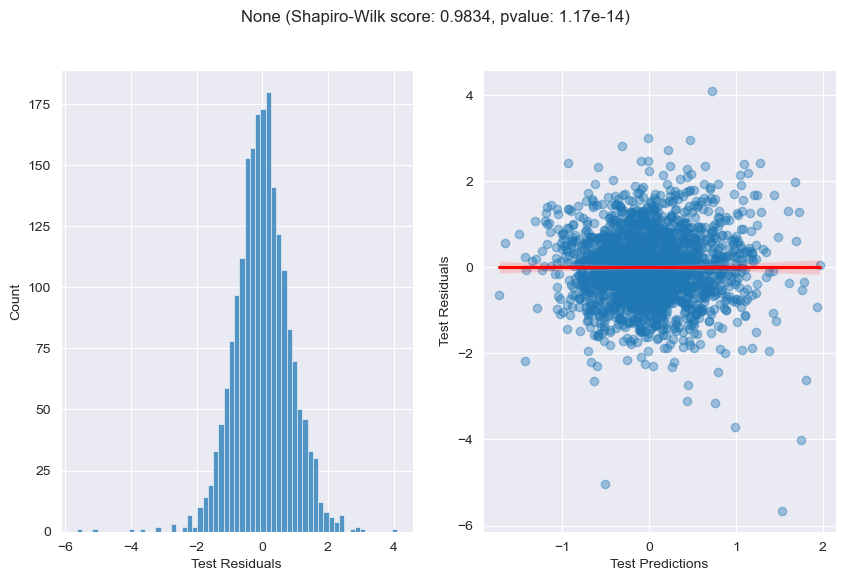

In [26]:
# check normality
check_residuals(X_train, y_train, lm)

#### Statsmodels OLS
Same results again

In [27]:
## Linear regression with statsmodels
ols = sm.OLS(y_train, X_train).fit()
print(ols.summary())

# top coefficients
print(f'__________\nTop positive coefs: \n__________\n{ols.params.sort_values(ascending=False).head()}')
print(f'__________\nTop negative coefs: \n__________\n{ols.params.sort_values(ascending=True).head()}')

# train score
pred = ols.predict(X_train)
ssr = (y_train - pred)**2
sst = (y_train - np.mean(y_train))**2
r2 = 1 - np.sum(ssr)/np.sum(sst)
print(f'Train R2: {r2:.4f}')

# test score
pred = ols.predict(X_test)
ssr = (y_test - pred)**2
sst = (y_test - np.mean(y_test))**2
r2 = 1 - np.sum(ssr)/np.sum(sst)
print(f'Test R2: {r2:.4f}')

                                  OLS Regression Results                                 
Dep. Variable:     PCA_dt_allinc_popstr   R-squared (uncentered):                   0.279
Model:                              OLS   Adj. R-squared (uncentered):              0.273
Method:                   Least Squares   F-statistic:                              48.96
Date:                  Sat, 07 Dec 2024   Prob (F-statistic):                   4.32e-131
Time:                          23:19:45   Log-Likelihood:                         -2549.9
No. Observations:                  2044   AIC:                                      5132.
Df Residuals:                      2028   BIC:                                      5222.
Df Model:                            16                                                  
Covariance Type:              nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
-------

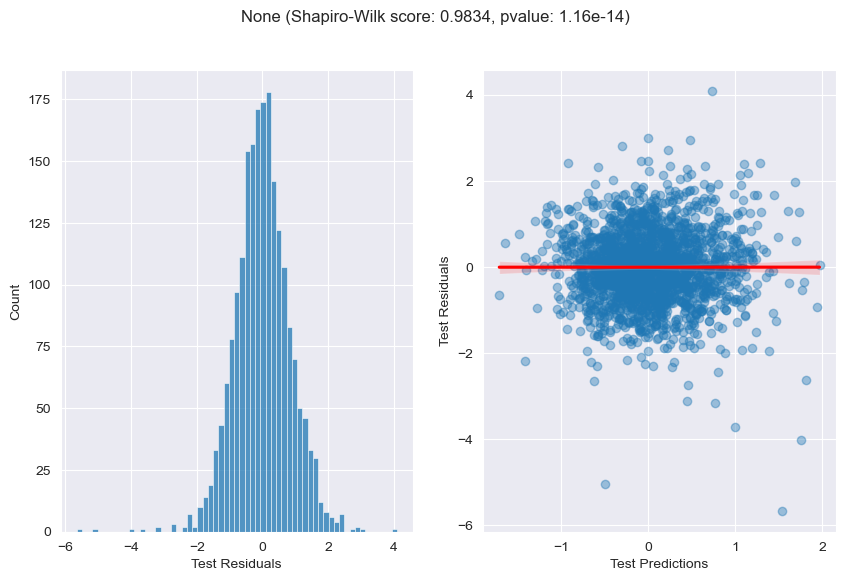

In [28]:
# check normality
check_residuals(X_train, y_train, ols)

### Random Forest

__________
Random Forest Regressor 
__________ 
OOB score: 0.3041
Top 10 most important features
                    features  importance
5              PCT_NHBLACK10    0.156195
2                 PCT_HISP10    0.144551
6              PCT_NHWHITE10    0.097386
9   healthy_restaurant_ratio    0.091064
8        healthy_store_ratio    0.088790
3          PCT_LACCESS_POP15    0.080897
4         PCT_LACCESS_SNAP15    0.071049
10                 sum_farms    0.070459
7     2010_Census_Population    0.066390
0           DIRSALES_FARMS12    0.062298
Test R2: 0.2847


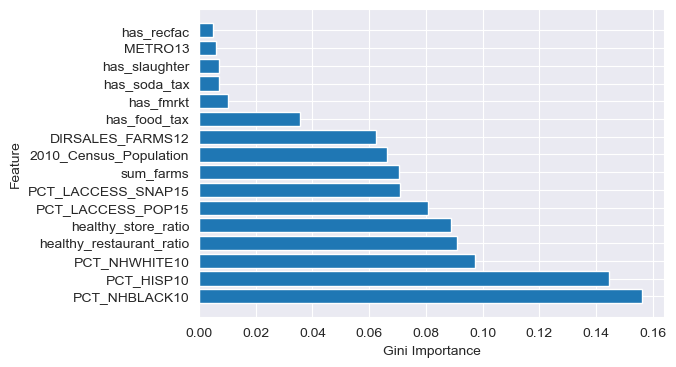

In [31]:
## RandomForest
rfm = RandomForestRegressor(random_state=10, oob_score=True).fit(X_train, y_train)
var_imp = pd.DataFrame({'features': X_train.columns, 'importance': rfm.feature_importances_})
var_imp.sort_values('importance', ascending=False, inplace=True)
print(f'__________\nRandom Forest Regressor \n__________ \nOOB score: {rfm.oob_score_:.4f}')
print(f'Top 10 most important features\n{var_imp[:10]}')

# test score
print(f'Test R2: {rfm.score(X_test, y_test):.4f}')

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.barh(var_imp['features'], var_imp['importance'])
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.savefig('data/figures/gini_importance.png')
plt.show()

#### Random Forest Non-normalized test

In [30]:
## load dataset
data_set = 'raw_data'
# data_set = 'data_nonans'
df_test = pd.read_csv(f'data/{data_set}.csv', index_col='CountySt')

# select response var
select_var = 'PCA'
resp_vars = ['PCT_DIABETES_ADULTS13', 'HDM', 'PCA', 'Life Expectancy']
df_test.drop([v for v in resp_vars if v != select_var], axis=1, inplace=True)

# drop nans
all_nans = False
if all_nans:
    df_test.dropna(inplace=True, axis=0)
else:
    df_test.dropna(subset=select_var, inplace=True)
    df_test['nans'] = df_test.isna().any(axis=1)   

In [31]:
## X, y
y = df_test[select_var]
x_cols = [c for c in df_test.columns if c != select_var]
X = df_test[x_cols]

## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [32]:
## Random Forest
rfm = RandomForestRegressor(random_state=10, oob_score=True, n_estimators=150).fit(X_train, y_train)
var_imp = pd.DataFrame({'features': X_train.columns, 'importance': rfm.feature_importances_})
print(f'__________\nRandom Forest Regressor \n__________ \nOOB score: {rfm.oob_score_:.4f}')
print(f'Top 10 most important features\n{var_imp.sort_values('importance', ascending=False)[:10]}')

__________
Random Forest Regressor 
__________ 
OOB score: 0.7307
Top 10 most important features
              features  importance
16          MEDHHINC15    0.368574
32        PC_SNAPBEN12    0.106963
22          PCT_HISP10    0.072765
29       PCT_NHBLACK10    0.033123
36          SNAPSPTH12    0.031521
24  PCT_LACCESS_HHNV15    0.026267
12          FOOD_TAX14    0.025253
21       PCT_65OLDER10    0.024749
4    CHIPSTAX_STORES14    0.024519
20     PCT_18YOUNGER10    0.016707
